This notebook implements the active Learning strategies in the basic setting, while using an oop approach. The goal of this notebook is to
* clearify the process
* use algorithm settings accross multiple runs, without redefining them
* create results for the main expriment for all selection criteria and model classes
    * This goal needs to be revised, due to the computational resources
    * Therefore the selected model classes are
        - Random Forest, because it was used in previous study
        - Kernel Ridge Regression, due to its fast computational time and good results in the GridSearchCrossValidation Hyperparameter Search
        - Partial Least Squares Regression
    * If another Model Class should be tested, XGB could be integrated, because of its provinience as a non-sklearn native regression method


# Setup
## Define the PATHS

In [1]:
import sys

basepath = "../"  # Project directory
sys.path.append(basepath)
# AL Scripts
AL_SCRIPTS_PATH = basepath + "al_lib/"

sys.path.append({AL_SCRIPTS_PATH})

from al_lib.active_learning_setting import ActiveLearningPaths

PATHS = ActiveLearningPaths()
(DATA_PATH, FIGURE_PATH, ENV_PATH, RESULTS_PATH, LOG_DIR) = PATHS
sys.path.extend(PATHS)

sys.path

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 {'../al_lib/'},
 '../',
 '../04_Active_Learning/results/',
 '../data/',
 '../04_Active_Learning/results/figures/',
 '../04_Active_Learning/logs/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../data/',
 '../04_Active_Learning/results/figures/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../04_Active_Learning/results/',
 '../04_Active_Learning/logs/']

# Define limitation of threads

In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
os.environ["OPENBLAS_NUM_THREADS"] = "20"
os.environ["VECLIB_MAXIMUM_THREADS"] = "20"
os.environ["NUMEXPR_NUM_THREADS"] = "20"

## Include a logger

In [3]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
date = datetime.datetime.now().strftime("%Y-%m-%d")
# date = now.strftime("%Y-%m-%d")
log_file_name = f"{date}_active_learning.log"
log_file_path = f"{LOG_DIR}{log_file_name}"

# Create logger
logging = create_logger(__name__, log_file_path=log_file_path)
# Usage of the logger as follows:
logging.info("Logging started")
logging.info(f"log stored at: {log_file_path}")

2024-08-24 22:36:39 - INFO - Logging started
2024-08-24 22:36:39 - INFO - log stored at: ../04_Active_Learning/logs/2024-08-24_active_learning.log


# Imports
## Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge as KRR
import pandas as pd
import time

### sklearn warnings

In [5]:
## Turn of sklearn warnings
from warnings import simplefilter
import warnings

from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings(
    "ignore", message=".*y residual is constant*.", category=UserWarning, append=False
)
logging.info('Warning "y residual is constant" turned off')

2024-08-24 22:36:41 - INFO - Warning "y residual is constant" turned off


### Import Data

In [6]:
# Define the datafile

data_name = "dpsDeriv1200.csv"

datafile = DATA_PATH + data_name

from al_lib.helper_functions import import_dpsDeriv1200

data = import_dpsDeriv1200(datafile)
logging.info(f"Data loaded and preprocessed from {datafile}")

2024-08-24 22:36:41 - INFO - Data loaded and preprocessed from ../data/dpsDeriv1200.csv


## Import Timer

In [7]:
start = time.time()
for i in range(100):
    pass
end = time.time()
print(f"Time taken for 100 passes: {end-start}")

Time taken for 100 passes: 0.00011134147644042969


## Split into feature and target variables

In [8]:
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((1290, 410), (1290,))

## Validation

since not every regression method is able to estimate its prediction accuracy, a split of the data is retained as validation set. 

In [9]:
# count the number of columns with std = 0.0 in X
logging.info(f"{(X.std() == 0.0).sum()} Columns dropped, where std = 0.0 in X")

# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
logging.info(
    f"X: {X.shape},y: {y.shape} Dimensions after dropping columns with std = 0.0"
)

2024-08-24 22:36:41 - INFO - 0 Columns dropped, where std = 0.0 in X
2024-08-24 22:36:41 - INFO - X: (1290, 410),y: (1290,) Dimensions after dropping columns with std = 0.0


# Train/Test/Validation Split

In [10]:
from sklearn.model_selection import train_test_split
from al_lib.helper_functions import calc_set_sizes


def _split_data(
    X, y, random_state=None, test_size=None, validation_size=None, logging=None
):
    """
    Split the data into training, test and validation set
    """
    if random_state is None:
        assert random_state is not None, "Random state not provided"
    if test_size is None:
        test_size = 0.3
    if validation_size is None:
        validation_size = 0.1

    # retain 10% of the data for validation
    (
        X_remainder,
        X_val,
        y_remainder,
        y_val,
    ) = train_test_split(X, y, test_size=validation_size, random_state=random_state)

    # split the remainder into training and test (30%) set
    X_train, X_test, y_train, y_test = train_test_split(
        X_remainder, y_remainder, test_size=test_size, random_state=random_state
    )
    calc_set_sizes(X_train, X_test, X_val, logging)
    # assert the shapes for the sets and raise an error if they are not equal
    assert (
        X_train.shape[0] + X_test.shape[0] + X_val.shape[0] == X.shape[0]
    ), "Sum of samples in Train/Test/Validation set not equal to total samples"
    assert (
        X_train.shape[1] == X_test.shape[1] == X_val.shape[1] == X.shape[1]
    ), "Number of features in Train/Test/Validation set not equal to total features"
    assert (
        y_train.shape[0] + y_test.shape[0] + y_val.shape[0] == y.shape[0]
    ), "Sum of Sample-targets in Train/Test/Validation set not equal to total samples"
    assert (
        X_train.shape[0] == y_train.shape[0]
    ), "Number of samples not equal to number of targets in Train set"
    assert (
        X_test.shape[0] == y_test.shape[0]
    ), "Number of samples not equal to number of targets in Test set"
    assert (
        X_val.shape[0] == y_val.shape[0]
    ), "Number of samples not equal to number of targets in Validation set"

    logging.info(f"Shapes of Train/Test/Validation set verified")
    logging.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    logging.info(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    logging.info(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

    return X_train, X_test, X_val, y_train, y_test, y_val

In [11]:
random_state = 12345

validation_size = 0.1
test_size = 0.3


X_train, X_test, X_val, y_train, y_test, y_val = _split_data(
    X, y, random_state=random_state, logging=logging
)

2024-08-24 22:36:41 - INFO - Training set: 812 (62.95%)
2024-08-24 22:36:41 - INFO - Test set: 349 (27.05%)
2024-08-24 22:36:41 - INFO - Validation set: 129 (10.0%)
2024-08-24 22:36:41 - INFO - Shapes of Train/Test/Validation set verified
2024-08-24 22:36:41 - INFO - X_train: (812, 410), y_train: (812,)
2024-08-24 22:36:41 - INFO - X_test: (349, 410), y_test: (349,)
2024-08-24 22:36:41 - INFO - X_val: (129, 410), y_val: (129,)


# Model Parameters and Model Methods

The optimal model parameters according to the CV Results are used to to fit the individual models. 

In [12]:
# Import the Regressors

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import HistGradientBoostingRegressor as HGB
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.cross_decomposition import PLSRegression as PLS
from xgboost import XGBRegressor as XGB

# Define the regressors
Regressors = [RF, KRR, HGB, MLP, PLS, XGB]

In [43]:
# import the rscv model parameters from 03_Modelling/03_1_rscv

rscv_results_dir = basepath + "03_Modelling/03_1_rscv/rscv_results/"
gscv_results_dir = basepath + "03_Modelling/03_2_gscv/gscv_results/"

# models tested
models = ["hgb", "krr", "mlp", "pls", "rf", "xgb"]
models_available = {}
optimal_params = {}
rmse_from_cv = {}

for model in models:

    try:
        gscv_results = pd.read_csv(gscv_results_dir + f"{model}_gscv_results.csv")
        # id the best parameters via min of RMSE
        opt_run = gscv_results.loc[gscv_results["RMSE"].idxmin()]
        # extract the optimal parameters
        optimal_params[model] = opt_run["params"]
        # convert the parameters to a dictionary
        optimal_params[model] = eval(optimal_params[model])
        # retrieve the optimal RMSE
        rmse_from_cv[model] = opt_run["RMSE"]
        # convert the RMSE to a float, round, and assign integer value
        rmse_from_cv[model] = round(float(rmse_from_cv[model]), 1)
        models_available[model] = True
        logging.info(
            f"Loaded the gscv results: {model} from {gscv_results_dir + f'{model}_gscv_results.csv'}"
        )

    except FileNotFoundError:
        try:  # try to load the results of the rscv as a dataframe
            rscv_results = pd.read_csv(rscv_results_dir + f"{model}_rscv_results.csv")
            # id the best parameters via min of RMSE
            opt_run = rscv_results.loc[rscv_results["RMSE"].idxmin()]
            # extract the optimal parameters
            optimal_params[model] = opt_run["params"]
            # convert the parameters to a dictionary
            optimal_params[model] = eval(optimal_params[model])
            # retrieve the optimal RMSE
            rmse_from_cv[model] = opt_run["RMSE"]
            # convert the RMSE to a float, round, and assign integer value
            rmse_from_cv[model] = round(float(rmse_from_cv[model]), 0)
            models_available[model] = True
            logging.info(
                f"Loaded the rscv results: {model} from {rscv_results_dir + f'{model}_rscv_results.csv'}"
            )
        except FileNotFoundError:
            models_available[model] = False
            logging.error(
                f"Error loading the rscv results: {model} from {rscv_results_dir + f'{model}_rscv_results.csv'}"
            )

2024-08-24 23:11:42 - INFO - Loaded the rscv results: hgb from ../03_Modelling/03_1_rscv/rscv_results/hgb_rscv_results.csv
2024-08-24 23:11:42 - INFO - Loaded the gscv results: krr from ../03_Modelling/03_2_gscv/gscv_results/krr_gscv_results.csv
2024-08-24 23:11:42 - INFO - Loaded the gscv results: mlp from ../03_Modelling/03_2_gscv/gscv_results/mlp_gscv_results.csv
2024-08-24 23:11:42 - INFO - Loaded the gscv results: pls from ../03_Modelling/03_2_gscv/gscv_results/pls_gscv_results.csv
2024-08-24 23:11:42 - INFO - Loaded the gscv results: rf from ../03_Modelling/03_2_gscv/gscv_results/rf_gscv_results.csv
2024-08-24 23:11:42 - INFO - Loaded the rscv results: xgb from ../03_Modelling/03_1_rscv/rscv_results/xgb_rscv_results.csv


Return the model parameters which are used to perform active learning. These are important, since they potentially influence the performance of the AL-processes in an influental manner.

In [14]:
for model in models_available:
    if models_available[model]:
        logging.info(
            f"Optimal parameters (GSCV) for {model} with RMSE {rmse_from_cv[model]}: {optimal_params[model]}"
        )
    else:
        logging.info(
            f"Optimal parameters (RSCV) for {model} with RMSE {rmse_from_cv[model]}: {optimal_params[model]}"
        )

2024-08-24 22:36:41 - INFO - Optimal parameters (GSCV) for hgb with RMSE 97.0: {'learning_rate': np.float64(0.04262389603635252), 'loss': 'squared_error', 'max_iter': 267, 'max_leaf_nodes': 16, 'min_samples_leaf': 8}
2024-08-24 22:36:41 - INFO - Optimal parameters (GSCV) for krr with RMSE 101.0: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'rbf'}
2024-08-24 22:36:41 - INFO - Optimal parameters (GSCV) for mlp with RMSE 138.0: {'activation': 'identity', 'alpha': np.float64(0.030087981364603892), 'early_stopping': np.True_, 'hidden_layer_sizes': np.int64(195), 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1381305094147183)}
2024-08-24 22:36:41 - INFO - Optimal parameters (GSCV) for pls with RMSE 110.0: {'copy': np.True_, 'max_iter': np.int64(201), 'n_components': np.int64(14), 'scale': np.False_, 'tol': np.float64(0.3000640615051812)}
2024-08-24 22:36:41 - INFO - Optimal parameters (GSCV) for rf with RMSE 117.0: {'max_depth': np.i

In [24]:
RESULTS_PATH

'../04_Active_Learning/results/'

In [29]:
# generate object with the optimized parameters to hand over to the Regressors
for key in optimal_params.keys():
    # generate a global variable with the optimal parameters
    globals()[f"params_{key}"] = optimal_params[key]


for key in optimal_params.keys():
    logging.info(f"Optimal parameters for {key}: {optimal_params[key]}")

# document the optimal parameters for the regressors in a .csv-file
    

2024-08-24 22:49:18 - INFO - Optimal parameters for hgb: {'learning_rate': np.float64(0.04262389603635252), 'loss': 'squared_error', 'max_iter': 267, 'max_leaf_nodes': 16, 'min_samples_leaf': 8}
2024-08-24 22:49:18 - INFO - Optimal parameters for krr: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'rbf'}
2024-08-24 22:49:18 - INFO - Optimal parameters for mlp: {'activation': 'identity', 'alpha': np.float64(0.030087981364603892), 'early_stopping': np.True_, 'hidden_layer_sizes': np.int64(195), 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1381305094147183)}
2024-08-24 22:49:18 - INFO - Optimal parameters for pls: {'copy': np.True_, 'max_iter': np.int64(201), 'n_components': np.int64(14), 'scale': np.False_, 'tol': np.float64(0.3000640615051812)}
2024-08-24 22:49:18 - INFO - Optimal parameters for rf: {'max_depth': np.int64(16), 'max_features': np.int64(7), 'min_samples_split': np.int64(6), 'n_estimators': np.int64(75)}
2024-08-24 

hgb {'learning_rate': np.float64(0.04262389603635252), 'loss': 'squared_error', 'max_iter': 267, 'max_leaf_nodes': 16, 'min_samples_leaf': 8}
krr {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'rbf'}
mlp {'activation': 'identity', 'alpha': np.float64(0.030087981364603892), 'early_stopping': np.True_, 'hidden_layer_sizes': np.int64(195), 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1381305094147183)}
pls {'copy': np.True_, 'max_iter': np.int64(201), 'n_components': np.int64(14), 'scale': np.False_, 'tol': np.float64(0.3000640615051812)}
rf {'max_depth': np.int64(16), 'max_features': np.int64(7), 'min_samples_split': np.int64(6), 'n_estimators': np.int64(75)}
xgb {'colsample_bytree': np.float64(0.9024510488355479), 'gamma': np.float64(0.24338297203210052), 'learning_rate': np.float64(0.08035726078424349), 'max_depth': 6, 'n_estimators': 92, 'reg_alpha': np.float64(0.08686856214001293), 'reg_lambda': np.float64(0.49919891319367615)

# Active Learning Setup

The Basic Active Learning Experiment follows the specifications:

* Implementation of each Sampling Strategy in a Modular fashion
* Selecting the inital samples randomly
* Refitting the model after each selected sample
* Runing the experiment n-fold with differing random states
* Calculation of mean performance with confidence intervalls
* Visualizing the results

# Importing the sampling strategies

In [16]:
from al_lib.selection_criteria import (
    _random_selection,
    _gsx_selection,
    _gsy_selection,
    _uncertainty_selection,
    _distance_weighing,
)

# Defining the active Learning Framework

In [17]:
from al_lib.helper_functions import _validate_parameters
from al_lib.helper_functions import _rnd_initial_sampling
from al_lib.helper_functions import rmse_func
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit


def active_learning(
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    logging,
    model_class=None,
    model_params={},
    selection_criterion=None,
    n_iterations=None,
    n_samples_per_it=None,
    init_sample_size=None,
    random_state=None,
    n_jobs=None,
    results_file=None,
    **kwargs,
):
    """
    Perform active learning with the given parameters.

    Active Learning selects additional samples for the training set from
    provided pool of samples. The selection is based on a selection criterion,
    which can be selected from implemented criteria. The active
    learning process is repeated for n_iterations. The model is retrained after
    each iteration with the updated training set.

    Parameters
    ----------
    X_i : pd.DataFrame
        The features of the set (i = (train, test, val))
    y_i : pd.Series
        The target of the set (i = (train, test, val))
    model_class : model class, either from sklearn or xgboost
        The model to be used for the active learning process
    model_params : dict
        The parameters for the model
    selection_criterion : function
        The selection criterion to be used for the active learning process
    n_iterations : int, optional (default=50)
        The number of iterations for the active learning process
    n_samples_per_it : int, optional (default=1)
        The number of samples to be selected in each iteration
    init_sample_size : int, optional (default=10)
        The initial sample size for initial model
    random_state : int, optional
        The random state for the active learning process
    n_jobs : int, optional
        The number of kernels to be used for the active learning process
    results_file : str, optional
        The path to the file to store the results of the active learning process
        If provided, the results are stored as a csv file from a pandas dataframe
    **kwargs : dict
        Additional keyword arguments to be used for the selection criterion

    Returns
    -------
    tuple containing:
        rmse_test : np.array
            The RMSE of the model with the training set after each iteration
        rmse_validation : np.array
            The RMSE of the model with the validation set after each iteration
        samples_selected : np.array
            The samples selected in each iteration
        rmse_full : float
            The RMSE of the model trained with all training samples

    """
    if "n_fold" in kwargs:
        n_fold = kwargs["n_fold"]
    else:
        n_fold = 3  # default value

    # _validate_parameters(
    #     X_train,
    #     y_train,
    #     model_class=None,
    #     model_params={},
    #     selection_criterion=None,
    #     n_iterations=None,
    #     n_samples_per_it=None,
    #     init_sample_size=None,
    # )

    logging.info(f"Size of X_train: {X_train.shape}")
    logging.info(f"Size of y_train: {y_train.shape}")
    logging.info(f"Model_class: {model_class}")
    logging.info(f"Modelling parameters: {model_params}")
    logging.info(f"Selection Criterion: {selection_criterion}")
    logging.info(f"Key word arguments: {kwargs}")

    if n_samples_per_it is None:
        n_samples_per_it = 1
    if init_sample_size is None:
        init_sample_size = 10
    if n_iterations is None:
        n_iterations = 50
    if random_state is None:
        random_state = 12345

    # Initialize the model
    model = model_class(**model_params)
    # Initialize the active learning model
    X_Pool = X_train
    y_Pool = y_train

    # prepare the output objects
    rmse_test = np.zeros(n_iterations)
    rmse_validation = np.zeros(n_iterations)
    samples_selected = np.zeros(n_iterations)
    selection_value_storage = np.zeros(n_iterations)

    # initialize the learned set as a empty dataframe
    X_Learned = pd.DataFrame()
    y_Learned = pd.Series()

    # Initialize the model
    X_Learned, y_Learned, X_Pool, y_Pool = _rnd_initial_sampling(
        X_Pool,
        X_Learned,
        y_Pool,
        y_Learned,
        init_sample_size,
        random_state=random_state,
    )
    model.fit(X_Learned, y_Learned)

    logging.info(f"Initial model fitted with {init_sample_size} samples")
    logging.info("--Active Learning starts--")

    for it in range(n_iterations):
        logging.info(f"Active Learning with {selection_criterion} - iteration: {it}")

        y_pred_pool = model.predict(X_Pool)
        y_pred_pool = pd.Series(y_pred_pool, index=X_Pool.index)

        sample_id, selection_value = selection_criterion(
            X_Pool=X_Pool,
            y_Pool=y_Pool,
            X_Learned=X_Learned,
            y_Learned=y_Learned,
            y_pred_pool=y_pred_pool,
            n_fold=n_fold,
            random_state=random_state,
            logging=logging,
            model=model,
            n_jobs=n_jobs,
            kwargs=kwargs,
        )

        samples_selected[it] = sample_id
        selection_value_storage[it] = selection_value

        # Update the Sample sets
        x_new = X_Pool.loc[[sample_id]]
        y_new = y_Pool.loc[[sample_id]]
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        X_Pool = X_Pool.drop(index=sample_id)
        y_Pool = y_Pool.drop(index=sample_id)

        # Update the Model
        # retrain model on the new full data set and predict a new fit, if the n_samples_per_it is reached
        if n_samples_per_it == None or n_samples_per_it == 1:
            model.fit(X_Learned, y_Learned)
            y_pred = model.predict(X_test)
            rmse_test[it] = rmse_func(y_test, y_pred)
            y_pred_val = model.predict(X_val)
            rmse_validation[it] = rmse_func(y_val, y_pred_val)
        if it % n_samples_per_it == 0 or it != 0:
            model.fit(X_Learned, y_Learned)
            y_pred = model.predict(X_test)
            rmse_test[it] = rmse_func(y_test, y_pred)
            y_pred_val = model.predict(X_val)
            rmse_validation[it] = rmse_func(y_val, y_pred_val)

    # write results into outputifle
    if results_file is not None:
        results = pd.DataFrame(
            {
                "rmse_test": rmse_test,
                "rmse_validation": rmse_validation,
                "samples_selected": samples_selected,
                "selection_value": selection_value_storage,
            }
        )
        results.to_csv(results_file, index=False, mode="a")
        logging.info(f"Results written to {results_file}")

    # calc the rmse for the model including all training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_full = rmse_func(y_test, y_pred)

    # # plot the rmse over the iterations
    # plt.plot(range(n_iterations)[1:], rmse_test[1:])
    # # add a line for the model with all training samples
    # plt.axhline(y=rmse_full, color="r", linestyle="--")
    # selection_criterion_str = str(selection_criterion).split(" ")[1]
    # plt.title(
    #     f"RMSE over Iterations with {model_class} and\n {selection_criterion} as selection criterion \n {selection_criterion_str} as selection criterion"
    # )
    # plt.xlabel("Iteration")
    # plt.ylabel("RMSE")
    # plt.show()
    return (
        rmse_test,
        rmse_validation,
        samples_selected,
        selection_value_storage,
        rmse_full,
    )

In [18]:
def test_active_learning():
    """
    Function to test the active learning function
    """
    from al_lib.helper_functions import _create_test_data
    from al_lib.helper_functions import _test_params_krr

    # create test data
    X_train, X_test, X_val, y_train, y_test, y_val = _create_test_data(logging=logging)
    # Perform active Learning for n_iterations
    n_iterations = 5
    n_samples_per_it = 1
    initial_sample_size = 10
    model_params = _test_params_krr()
    model_class = KRR
    # Perform active learning
    rmse_test, rmse_validation, samples_selected, selection_value_storage, rmse_full = (
        active_learning(
            X_train,
            X_test,
            X_val,
            y_train,
            y_test,
            y_val,
            logging,
            model_class=model_class,
            model_params=model_params,
            selection_criterion=_uncertainty_selection,
            n_samples_per_it=n_samples_per_it,
            n_iterations=n_iterations,
            init_sample_size=initial_sample_size,
        )
    )

    return (
        rmse_test,
        rmse_validation,
        samples_selected,
        selection_value_storage,
        rmse_full,
    )


rmse_test, rmse_validation, samples_selected, selection_value_storage, rmse_full = (
    test_active_learning()
)

assert (
    rmse_test.shape[0] == rmse_validation.shape[0] == samples_selected.shape[0]
), "Shapes of output arrays not equal"

2024-08-24 22:36:42 - INFO - Training set: 63 (63.0%)
2024-08-24 22:36:42 - INFO - Test set: 27 (27.0%)
2024-08-24 22:36:42 - INFO - Validation set: 10 (10.0%)
2024-08-24 22:36:42 - INFO - Size of X_train: (63, 3)
2024-08-24 22:36:42 - INFO - Size of y_train: (63,)
2024-08-24 22:36:42 - INFO - Model_class: <class 'sklearn.kernel_ridge.KernelRidge'>
2024-08-24 22:36:42 - INFO - Modelling parameters: {'alpha': 1.0, 'kernel': 'linear', 'gamma': None, 'degree': 3, 'coef0': 1}
2024-08-24 22:36:42 - INFO - Selection Criterion: <function _uncertainty_selection at 0x7f79f2216020>
2024-08-24 22:36:42 - INFO - Key word arguments: {}
/home/fhwn.ac.at/202375/Zamberger_thesis_AL2024/04_Active_Learning/../al_lib/helper_functions.py:287: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y

2024-08-24 22:36:42 - INFO - Training set: 63 (63.0%)
2024-08-24 22:36:42 - INFO - Test set: 27 (27.0%)
2024-08-24 22:36:42 - INFO - Validation set: 10 (10.0%)
2024-08-24 22:36:42 - INFO - Size of X_train: (63, 3)
2024-08-24 22:36:42 - INFO - Size of y_train: (63,)
2024-08-24 22:36:42 - INFO - Model_class: <class 'sklearn.kernel_ridge.KernelRidge'>
2024-08-24 22:36:42 - INFO - Modelling parameters: {'alpha': 1.0, 'kernel': 'linear', 'gamma': None, 'degree': 3, 'coef0': 1}
2024-08-24 22:36:42 - INFO - Selection Criterion: <function _uncertainty_selection at 0x7f79f2216020>
2024-08-24 22:36:42 - INFO - Key word arguments: {}
/home/fhwn.ac.at/202375/Zamberger_thesis_AL2024/04_Active_Learning/../al_lib/helper_functions.py:287: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y

2024-08-24 22:36:42 - INFO - Active Learning with <function _uncertainty_selection at 0x7f79f2216020> - iteration: 11
2024-08-24 22:36:42 - INFO - Active Learning with <function _uncertainty_selection at 0x7f79f2216020> - iteration: 12
2024-08-24 22:36:42 - INFO - Active Learning with <function _uncertainty_selection at 0x7f79f2216020> - iteration: 13
2024-08-24 22:36:42 - INFO - Active Learning with <function _uncertainty_selection at 0x7f79f2216020> - iteration: 14
2024-08-24 22:36:42 - INFO - Size of X_train: (63, 3)
2024-08-24 22:36:42 - INFO - Size of y_train: (63,)
2024-08-24 22:36:42 - INFO - Model_class: <class 'sklearn.kernel_ridge.KernelRidge'>
2024-08-24 22:36:42 - INFO - Modelling parameters: {'alpha': 1.0, 'kernel': 'linear', 'gamma': None, 'degree': 3, 'coef0': 1}
2024-08-24 22:36:42 - INFO - Selection Criterion: <function _uncertainty_selection at 0x7f79f2216020>
2024-08-24 22:36:42 - INFO - Key word arguments: {}
/home/fhwn.ac.at/202375/Zamberger_thesis_AL2024/04_Active

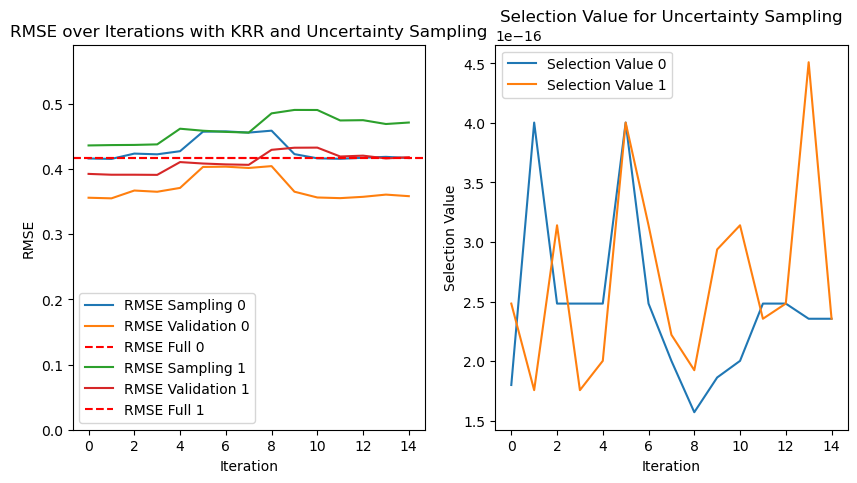

In [19]:
# perform active learning twice and generate result plots

def test_active_learning_twice():
    """
    Function to test the active learning function
    """
    from al_lib.helper_functions import _create_test_data
    from al_lib.helper_functions import _test_params_krr

    # create test data
    X_train, X_test, X_val, y_train, y_test, y_val = _create_test_data(logging=logging)
    # Perform active Learning for n_iterations
    n_iterations = 15
    n_samples_per_it = 1
    initial_sample_size = 10
    model_params = _test_params_krr()
    model_class = KRR
    # Perform active learning using a loop, store the results for each iteration

    results = pd.DataFrame()
    for i in range(2):
        random_state = 12345 + i

        (
            rmse_test,
            rmse_validation,
            samples_selected,
            selection_value_storage,
            rmse_full,
        ) = active_learning(
            X_train,
            X_test,
            X_val,
            y_train,
            y_test,
            y_val,
            logging,
            model_class=model_class,
            model_params=model_params,
            selection_criterion=_uncertainty_selection,
            n_samples_per_it=n_samples_per_it,
            n_iterations=n_iterations,
            init_sample_size=initial_sample_size,
            random_state=random_state,
        )
        results[f"rmse_test_{i}"] = rmse_test
        results[f"rmse_validation_{i}"] = rmse_validation
        results[f"samples_selected_{i}"] = samples_selected
        results[f"rmse_full_{i}"] = rmse_full
        results[f"selection_value_{i}"] = selection_value_storage

    # id the range for the y axis
    max_y_test = max([results[f"rmse_test_{i}"].max() for i in range(2)])
    max_y_val = max([results[f"rmse_validation_{i}"].max() for i in range(2)])
    max_y = max(max_y_test, max_y_val)

    # plot the results

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot RMSE for each iteration
    for i in range(2):
        ax1.plot(
            range(n_iterations), results[f"rmse_test_{i}"], label=f"RMSE Sampling {i}"
        )
        ax1.plot(
            range(n_iterations),
            results[f"rmse_validation_{i}"],
            label=f"RMSE Validation {i}",
        )
        ax1.axhline(
            y=results[f"rmse_full_{i}"][0],
            color="r",
            linestyle="--",
            label=f"RMSE Full {i}",
        )

    ax1.set_title("RMSE over Iterations with KRR and Uncertainty Sampling")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("RMSE")
    ax1.legend()

    # Plot selection values for each iteration
    for i in range(2):
        ax2.plot(
            range(n_iterations),
            results[f"selection_value_{i}"],
            label=f"Selection Value {i}",
        )

    ax2.set_title("Selection Value for Uncertainty Sampling")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Selection Value")
    ax2.legend()

    # Set the y-axis limit for the RMSE plot based on the maximum RMSE value across both iterations
    max_y_test = max([results[f"rmse_test_{i}"].max() for i in range(2)])
    max_y_val = max([results[f"rmse_validation_{i}"].max() for i in range(2)])
    max_y = max(max_y_test, max_y_val)
    ax1.set_ylim(0, max_y + 0.1)

    plt.show()


test_active_learning_twice()

# Main Experiment

The main experiment compares the performance of the various selection strategies statistically. To this end each selection strategy is performed multiple times for each model-class. The results can be compared. 

In [20]:
# remove the model and the model parameters for the models that are not available
for model in models_available:
    if models_available[model] == False:
        # remove the model and the model parameters
        try:
            # remove the model from the models list
            models.remove(model)
        except KeyError:
            logging.info(f"Error deleting the parameters for model: {model}")
        try:
            del globals()[f"{model}"]
        except KeyError:
            logging.info(f"Error deleting the model: {model}")

In [21]:
# Define the models

models = ["rf", "krr", "hgb", "pls", "xgb"]
models_list = [RF, KRR, HGB, PLS, XGB]

params = [params_rf, params_krr, params_hgb, params_pls, params_xgb]

model_params_list = [{model: param} for model, param in zip(models_list, params)]

In [22]:
for model in model_params_list:
    # seperate the model class and the parameters
    model_class = list(model.keys())[0]
    model_params = model[model_class]
    logging.info(f"Model Class: {model_class}, with params: {model_params}")

2024-08-20 18:20:06 - INFO - Model Class: <class 'sklearn.ensemble._forest.RandomForestRegressor'>, with params: {'max_depth': np.int64(16), 'max_features': np.int64(7), 'min_samples_split': np.int64(6), 'n_estimators': np.int64(75)}
2024-08-20 18:20:06 - INFO - Model Class: <class 'sklearn.kernel_ridge.KernelRidge'>, with params: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'rbf'}
2024-08-20 18:20:06 - INFO - Model Class: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>, with params: {'learning_rate': np.float64(0.04262389603635252), 'loss': 'squared_error', 'max_iter': 267, 'max_leaf_nodes': 16, 'min_samples_leaf': 8}
2024-08-20 18:20:06 - INFO - Model Class: <class 'sklearn.cross_decomposition._pls.PLSRegression'>, with params: {'copy': np.True_, 'max_iter': np.int64(201), 'n_components': np.int64(14), 'scale': np.False_, 'tol': np.float64(0.3000640615051812)}
2024-08-20 18:20:06 - IN

In [23]:
selection_criteria = [
    {
        "criteria": _random_selection,
        "crit_name": "Random",
        "kwargs": {},
    },  #'random_state': random_state}},
    {"criteria": _gsx_selection, "crit_name": "GSx", "kwargs": {}},
    {"criteria": _gsy_selection, "crit_name": "GSy", "kwargs": {}},
    {
        "criteria": _uncertainty_selection,
        "crit_name": "Variance",
        "kwargs": {"n_fold": 3},
    },
    {"criteria": _distance_weighing, "crit_name": "IDW-variant", "kwargs": {}},
]

In [ ]:
# Main Experiment

AL_RESULTS_PATH = f"{RESULTS_PATH}al_result_tables/"

# number of active learning runs
n_al_iterations = 10
# Define the number of iterations for each active learning run
n_iterations = 250

# Define the number of samples to be queried in each iteration
n_samples_per_it = 1

# Define the initial sample size
init_sample_size = 30

# Define the random state
random_state = 12345

# Define the number of jobs
n_jobs = 20

# Define the output object

selection_criteria = [
    {
        "criteria": _random_selection,
        "crit_name": "Random",
        "kwargs": {},
    },  #'random_state': random_state}},
    {"criteria": _gsx_selection, "crit_name": "GSx", "kwargs": {}},
    {"criteria": _gsy_selection, "crit_name": "GSy", "kwargs": {}},
    {
        "criteria": _uncertainty_selection,
        "crit_name": "Variance",
        "kwargs": {"n_fold": 3},
    },
    {"criteria": _distance_weighing, "crit_name": "IDW-variant", "kwargs": {}},
]

# perform the active learning process

for model in model_params_list:
    start = time.time()
    model_class = list(model.keys())[0]
    model_params = model[model_class]
    results = pd.DataFrame()
    logging.info(f"Current model: {model}")
    for i in range(n_al_iterations):
        random_state = random_state + i
        logging.info(
            f"Active Learning iteration: {i} with random state: {random_state}"
        )
        # generate the data sets from full data
        X_train, X_test, X_val, y_train, y_test, y_val = _split_data(
            X, y, random_state=random_state, logging=logging
        )

        for criteria in selection_criteria:
            logging.info(
                f"Current criterion: {criteria['crit_name']} with kwargs: {criteria['kwargs']}"
            )
            # extract the model name
            model_name = str(model_class).split(".")[-1]
            selection_criteria_name = criteria["crit_name"]
            results_file = f"{AL_RESULTS_PATH}al_results_{models_available}_{criteria['crit_name']}.csv"
            kwargs = criteria.get("kwargs", {})
            (
                rmse_test,
                rmse_validation,
                samples_selected,
                selection_value_storage,
                rmse_full,
            ) = active_learning(
                X_train,
                X_test,
                X_val,
                y_train,
                y_test,
                y_val,
                logging=logging,
                model_class=model_class,
                model_params=model_params,
                selection_criterion=criteria["criteria"],
                n_iterations=n_iterations,
                n_samples_per_it=n_samples_per_it,
                init_sample_size=init_sample_size,
                random_state=random_state,
                n_jobs=n_jobs,
                results_file=None,
                **kwargs,
            )
            results[f"rmse_test_{model_name}_{criteria['crit_name']}_{i}"] = rmse_test
            results[f"rmse_val_{model_name}_{criteria['crit_name']}_{i}"] = (
                rmse_validation
            )
            results[f"sample_sel_{model_name}_{criteria['crit_name']}_{i}"] = (
                samples_selected
            )
            results[f"rmse_full_{model_name}_{criteria['crit_name']}_{i}"] = rmse_full
            results[f"selection_value_{model_name}_{criteria['crit_name']}_{i}"] = (
                selection_value_storage
            )
    # store the results in the global variables
    globals()[f"{model_name}_al_results"] = results
    logging.info(f"Results stored in global variable: {model_name}_al_results")

    # write the results to a csv file
    results.to_csv(f"{AL_RESULTS_PATH}al_results_{model_name}.csv")
    end = time.time()
    logging.info(f"Time taken for active learning with {model_name}: {end-start}")

# Visualize the results

In [24]:
# define the path to the data

from al_lib.results_vis import load_data
from al_lib.results_vis import _seperate_results_test
from al_lib.results_vis import _seperate_results_val
from al_lib.results_vis import _plot_rmse

In [25]:
# Import Data

TABLES_PATH = RESULTS_PATH + "al_result_tables/"
# load the data
filename_krr = "al_results_KernelRidge'>.csv"

data_krr = load_data(filename_krr, TABLES_PATH)

# rename the columns for better readability
for col in data_krr.columns:
    # rename the columns
    data_krr.rename(columns={col: col.replace("KernelRidge'>", "KRR")}, inplace=True)

data_krr.drop(columns=["Unnamed: 0"], inplace=True)
data_krr.head()

,rmse_test_KRR_Random_0,rmse_val_KRR_Random_0,sample_sel_KRR_Random_0,rmse_full_KRR_Random_0,selection_value_KRR_Random_0,rmse_test_KRR_GSx_0,rmse_val_KRR_GSx_0,sample_sel_KRR_GSx_0,rmse_full_KRR_GSx_0,selection_value_KRR_GSx_0,...,rmse_test_KRR_Variance_9,rmse_val_KRR_Variance_9,sample_sel_KRR_Variance_9,rmse_full_KRR_Variance_9,selection_value_KRR_Variance_9,rmse_test_KRR_IDW-variant_9,rmse_val_KRR_IDW-variant_9,sample_sel_KRR_IDW-variant_9,rmse_full_KRR_IDW-variant_9,selection_value_KRR_IDW-variant_9
0,182.894679,187.746625,662.0,89.555435,NaN,185.008640,190.057853,770.0,89.555435,0.061172,...,171.197682,162.983135,168.0,86.119907,3.241274e-10,175.681972,162.814140,256.0,86.119907,219.604013
1,182.726786,186.720215,767.0,89.555435,NaN,184.633329,189.073058,767.0,89.555435,0.055552,...,172.379537,162.885341,1187.0,86.119907,2.485620e-10,175.679299,162.811668,259.0,86.119907,211.914182
2,185.604885,188.317974,847.0,89.555435,NaN,184.143915,188.854502,787.0,89.555435,0.049992,...,173.856218,163.965291,1145.0,86.119907,3.681805e-10,168.142124,154.129854,293.0,86.119907,222.756214
3,173.408883,173.565253,430.0,89.555435,NaN,184.190365,188.239570,772.0,89.555435,0.047862,...,173.856582,163.964694,942.0,86.119907,2.580479e-10,167.427838,153.553576,258.0,86.119907,213.861255
4,171.842332,172.356494,329.0,89.555435,NaN,178.372307,172.079378,72.0,89.555435,0.046338,...,175.012505,161.246952,210.0,86.119907,3.332917e-10,167.325892,153.266494,969.0,86.119907,218.391983


In [26]:
# Import Data

TABLES_PATH = RESULTS_PATH + "al_result_tables/"
# load the data
filename_pls = "al_results_PLSRegression'>.csv"

data_pls = load_data(filename_pls, TABLES_PATH)

# rename the columns for better readability
for col in data_pls.columns:
    # rename the columns
    data_pls.rename(columns={col: col.replace("PLSRegression'>", "PLS")}, inplace=True)

data_pls.drop(columns=["Unnamed: 0"], inplace=True)
data_pls.head()

,rmse_test_PLS_Random_0,rmse_val_PLS_Random_0,sample_sel_PLS_Random_0,rmse_full_PLS_Random_0,selection_value_PLS_Random_0,rmse_test_PLS_GSx_0,rmse_val_PLS_GSx_0,sample_sel_PLS_GSx_0,rmse_full_PLS_GSx_0,selection_value_PLS_GSx_0,...,rmse_test_PLS_Variance_9,rmse_val_PLS_Variance_9,sample_sel_PLS_Variance_9,rmse_full_PLS_Variance_9,selection_value_PLS_Variance_9,rmse_test_PLS_IDW-variant_9,rmse_val_PLS_IDW-variant_9,sample_sel_PLS_IDW-variant_9,rmse_full_PLS_IDW-variant_9,selection_value_PLS_IDW-variant_9
0,140.050629,174.140332,105.0,101.01069,NaN,141.431484,175.790827,768.0,101.01069,0.078838,...,142.347370,145.985814,848.0,102.801786,17.600132,142.516982,145.442426,1218.0,102.801786,414.168753
1,142.038507,179.067581,22.0,101.01069,NaN,140.697473,176.187709,771.0,101.01069,0.075106,...,141.862052,146.285240,72.0,102.801786,21.078905,139.520001,147.250954,91.0,102.801786,576.038967
2,137.498160,165.220770,583.0,101.01069,NaN,142.598259,176.118317,770.0,101.01069,0.064303,...,140.342806,145.572034,1090.0,102.801786,20.226612,139.711469,147.353625,1090.0,102.801786,819.264923
3,135.116219,164.962887,644.0,101.01069,NaN,148.531165,177.175892,772.0,101.01069,0.049652,...,151.432431,143.160771,1193.0,102.801786,25.222835,139.086613,147.320688,1163.0,102.801786,877.406103
4,134.506621,165.162948,555.0,101.01069,NaN,148.478987,171.850905,1121.0,101.01069,0.045075,...,145.939901,142.517563,769.0,102.801786,20.772291,139.215959,149.069114,721.0,102.801786,585.678488


In [27]:
# Import Data
# load the data
filename_hgb = "al_results_HistGradientBoostingRegressor'>.csv"

data_hgb = load_data(filename_hgb, TABLES_PATH)

# rename the columns for better readability
for col in data_hgb.columns:
    # rename the columns
    data_hgb.rename(
        columns={col: col.replace("HistGradientBoostingRegressor'>", "HGB")},
        inplace=True,
    )

data_hgb.drop(columns=["Unnamed: 0"], inplace=True)
data_hgb.head()

,rmse_test_HGB_Random_0,rmse_val_HGB_Random_0,sample_sel_HGB_Random_0,rmse_full_HGB_Random_0,selection_value_HGB_Random_0,rmse_test_HGB_GSx_0,rmse_val_HGB_GSx_0,sample_sel_HGB_GSx_0,rmse_full_HGB_GSx_0,selection_value_HGB_GSx_0,...,rmse_test_HGB_Variance_9,rmse_val_HGB_Variance_9,sample_sel_HGB_Variance_9,rmse_full_HGB_Variance_9,selection_value_HGB_Variance_9,rmse_test_HGB_IDW-variant_9,rmse_val_HGB_IDW-variant_9,sample_sel_HGB_IDW-variant_9,rmse_full_HGB_IDW-variant_9,selection_value_HGB_IDW-variant_9
0,157.225616,167.985011,727.0,92.819675,NaN,160.563002,172.538839,771.0,92.819675,0.076051,...,145.705309,162.555953,750.0,90.523154,93.731040,145.705309,162.555953,750.0,90.523154,238.598781
1,175.357819,168.482291,757.0,92.819675,NaN,160.968381,170.421028,769.0,92.819675,0.067168,...,142.677774,156.782186,209.0,90.523154,93.384124,145.420172,157.508245,433.0,90.523154,356.572040
2,177.290685,172.672108,50.0,92.819675,NaN,160.389697,170.030888,770.0,92.819675,0.065345,...,149.304562,158.470004,1175.0,90.523154,82.390189,145.229924,160.251285,1282.0,90.523154,339.792417
3,174.103905,171.836049,725.0,92.819675,NaN,159.678224,166.574809,767.0,92.819675,0.059934,...,146.309007,154.262066,475.0,90.523154,100.304867,150.660360,163.556989,1011.0,90.523154,272.609702
4,175.166086,174.067043,891.0,92.819675,NaN,161.098386,169.061036,789.0,92.819675,0.045269,...,146.662153,156.397742,535.0,90.523154,94.341170,147.072475,157.904355,1018.0,90.523154,417.370280


In [28]:
# Import Data
# load the data
filename_rf = "al_results_RandomForestRegressor'>.csv"

data_rf = load_data(filename_rf, TABLES_PATH)

# rename the columns for better readability
for col in data_rf.columns:
    # rename the columns
    data_rf.rename(
        columns={col: col.replace("RandomForestRegressor'>", "RF")}, inplace=True
    )

data_rf.drop(columns=["Unnamed: 0"], inplace=True)
data_rf.head()

,rmse_test_RF_Random_0,rmse_val_RF_Random_0,sample_sel_RF_Random_0,rmse_full_RF_Random_0,selection_value_RF_Random_0,rmse_test_RF_GSx_0,rmse_val_RF_GSx_0,sample_sel_RF_GSx_0,rmse_full_RF_GSx_0,selection_value_RF_GSx_0,...,rmse_test_RF_Variance_9,rmse_val_RF_Variance_9,sample_sel_RF_Variance_9,rmse_full_RF_Variance_9,selection_value_RF_Variance_9,rmse_test_RF_IDW-variant_9,rmse_val_RF_IDW-variant_9,sample_sel_RF_IDW-variant_9,rmse_full_RF_IDW-variant_9,selection_value_RF_IDW-variant_9
0,143.612946,152.343467,1153.0,102.913798,NaN,141.399513,157.133928,771.0,102.038493,0.076621,...,158.117792,162.558487,707.0,106.40006,32.935684,166.689143,164.757803,901.0,108.761282,30046.022833
1,147.285242,160.648516,93.0,102.913798,NaN,143.122220,156.171449,787.0,102.038493,0.052425,...,159.759397,161.955461,89.0,106.40006,30.114673,163.763994,163.915617,477.0,108.761282,27046.765734
2,143.101515,156.913190,181.0,102.913798,NaN,136.881091,152.349536,789.0,102.038493,0.043088,...,154.435242,158.634879,902.0,106.40006,30.173035,163.633867,164.341652,405.0,108.761282,31222.222773
3,137.131434,153.653802,445.0,102.913798,NaN,143.569315,155.796625,696.0,102.038493,0.041979,...,161.167274,163.423888,38.0,106.40006,34.470698,160.632797,165.395222,1038.0,108.761282,27045.780583
4,142.867279,157.757793,995.0,102.913798,NaN,142.879759,156.701650,774.0,102.038493,0.041637,...,158.354047,165.090228,382.0,106.40006,35.412993,164.235097,168.322710,104.0,108.761282,24465.455255


In [29]:
# Import Data
# load the data
filename_xgb = "al_results_XGBRegressor'>.csv"

data_xgb = load_data(filename_xgb, TABLES_PATH)

# rename the columns for better readability
for col in data_xgb.columns:
    # rename the columns
    data_xgb.rename(columns={col: col.replace("XGBRegressor'>", "XGB")}, inplace=True)

data_xgb.drop(columns=["Unnamed: 0"], inplace=True)
data_xgb.head()

,rmse_test_XGB_Random_0,rmse_val_XGB_Random_0,sample_sel_XGB_Random_0,rmse_full_XGB_Random_0,selection_value_XGB_Random_0,rmse_test_XGB_GSx_0,rmse_val_XGB_GSx_0,sample_sel_XGB_GSx_0,rmse_full_XGB_GSx_0,selection_value_XGB_GSx_0,...,rmse_test_XGB_Variance_9,rmse_val_XGB_Variance_9,sample_sel_XGB_Variance_9,rmse_full_XGB_Variance_9,selection_value_XGB_Variance_9,rmse_test_XGB_IDW-variant_9,rmse_val_XGB_IDW-variant_9,sample_sel_XGB_IDW-variant_9,rmse_full_XGB_IDW-variant_9,selection_value_XGB_IDW-variant_9
0,150.589568,147.931821,1190.0,99.325904,NaN,150.486006,147.822203,768.0,99.325904,0.080175,...,139.988047,137.796264,836.0,85.424894,111.607121,139.988047,137.796264,836.0,85.424894,401.699632
1,147.221114,145.541399,212.0,99.325904,NaN,149.441945,147.598380,769.0,99.325904,0.067267,...,142.747751,145.655797,967.0,85.424894,79.528969,136.694364,133.175049,201.0,85.424894,278.986039
2,153.126090,150.546898,318.0,99.325904,NaN,146.346654,145.660249,770.0,99.325904,0.065374,...,139.621237,150.797529,503.0,85.424894,106.749559,136.447039,131.092758,257.0,85.424894,480.666194
3,149.195033,146.890536,572.0,99.325904,NaN,148.485747,149.207451,767.0,99.325904,0.059780,...,143.400380,146.716559,421.0,85.424894,85.183493,127.966108,123.933475,427.0,85.424894,445.294161
4,151.829045,150.266083,322.0,99.325904,NaN,146.406004,148.126764,787.0,99.325904,0.054563,...,140.119574,147.028470,1034.0,85.424894,88.399310,141.137249,134.340684,31.0,85.424894,676.048340


In [30]:
# Define Additional Functions, necessary

In [31]:
def _calculate_auc(results):  # test_rmse
    """
    Calculate the Area under the curve for each selection criteria from the
    post-processed results
    Parameters:
    results: list of dataframes
    Returns:
    aucs: list of tuples (AUC, std_rmse_mean_per_iteration, AUC_mean, auc_std)
        each tuple contains the AUC, the standard deviation of the AUC, the mean of the AUC and the standard deviation of the RMSE
        AUC: float, the area under the curve
        std_rmse_mean_per_iteration: float, the standard deviation of the RMSE for each iteration
        AUC_mean: float, the mean of the AUC
        auc_std: float, the standard deviation of the AUC
    """
    aucs = []
    for i, rmse in enumerate(results):  # for each selection criteria

        rmse_mean_per_iteration = rmse.mean(axis=1)  # axis = 1 -> row wise

        # calc the std for each iteration
        std_rmse_mean_per_iteration = rmse.std(axis=1).round(3)

        # calculate the area under the curve
        auc = sum(rmse_mean_per_iteration).__round__(1)

        # calculate the mean of the AUC
        auc_mean = np.mean(rmse_mean_per_iteration).__round__(1)

        # calculate the standard deviation of the RMSE for each iteration
        auc_std = rmse_mean_per_iteration.std().__round__(1)
        aucs.append((auc, std_rmse_mean_per_iteration, auc_mean, auc_std))
    return aucs

In [32]:
from al_lib.results_vis import combined_auc_plot


## main report function
def report_al_results(results, model_name, filepath, selection_criteria):
    test_rmse = _seperate_results_test(results=results, model_name=model_name)
    val_rmse = _seperate_results_val(results=results, model_name=model_name)
    # generate the test rmse plot
    _plot_rmse(
        test_rmse,
        selection_criteria=selection_criteria,
        model_name=model_name,
        title=f"Test RMSE for {model_name}",
        filepath=filepath + f"test_rmse_{model_name}.png",
    )
    # generate the validation rmse plot
    _plot_rmse(
        val_rmse,
        selection_criteria=selection_criteria,
        model_name=model_name,
        title=f"Validation RMSE for {model_name}",
        filepath=filepath + f"val_rmse_{model_name}.png",
    )

    # revised
    mean_auc_test = _calculate_auc(test_rmse)
    mean_auc_val = _calculate_auc(val_rmse)

    combined_auc_plot(
        mean_auc_test=mean_auc_test,
        mean_auc_val=mean_auc_val,
        model_name=model_name,
        filepath=filepath,
        selection_criteria=selection_criteria,
    )

In [33]:
data_krr.head()

,rmse_test_KRR_Random_0,rmse_val_KRR_Random_0,sample_sel_KRR_Random_0,rmse_full_KRR_Random_0,selection_value_KRR_Random_0,rmse_test_KRR_GSx_0,rmse_val_KRR_GSx_0,sample_sel_KRR_GSx_0,rmse_full_KRR_GSx_0,selection_value_KRR_GSx_0,...,rmse_test_KRR_Variance_9,rmse_val_KRR_Variance_9,sample_sel_KRR_Variance_9,rmse_full_KRR_Variance_9,selection_value_KRR_Variance_9,rmse_test_KRR_IDW-variant_9,rmse_val_KRR_IDW-variant_9,sample_sel_KRR_IDW-variant_9,rmse_full_KRR_IDW-variant_9,selection_value_KRR_IDW-variant_9
0,182.894679,187.746625,662.0,89.555435,NaN,185.008640,190.057853,770.0,89.555435,0.061172,...,171.197682,162.983135,168.0,86.119907,3.241274e-10,175.681972,162.814140,256.0,86.119907,219.604013
1,182.726786,186.720215,767.0,89.555435,NaN,184.633329,189.073058,767.0,89.555435,0.055552,...,172.379537,162.885341,1187.0,86.119907,2.485620e-10,175.679299,162.811668,259.0,86.119907,211.914182
2,185.604885,188.317974,847.0,89.555435,NaN,184.143915,188.854502,787.0,89.555435,0.049992,...,173.856218,163.965291,1145.0,86.119907,3.681805e-10,168.142124,154.129854,293.0,86.119907,222.756214
3,173.408883,173.565253,430.0,89.555435,NaN,184.190365,188.239570,772.0,89.555435,0.047862,...,173.856582,163.964694,942.0,86.119907,2.580479e-10,167.427838,153.553576,258.0,86.119907,213.861255
4,171.842332,172.356494,329.0,89.555435,NaN,178.372307,172.079378,72.0,89.555435,0.046338,...,175.012505,161.246952,210.0,86.119907,3.332917e-10,167.325892,153.266494,969.0,86.119907,218.391983


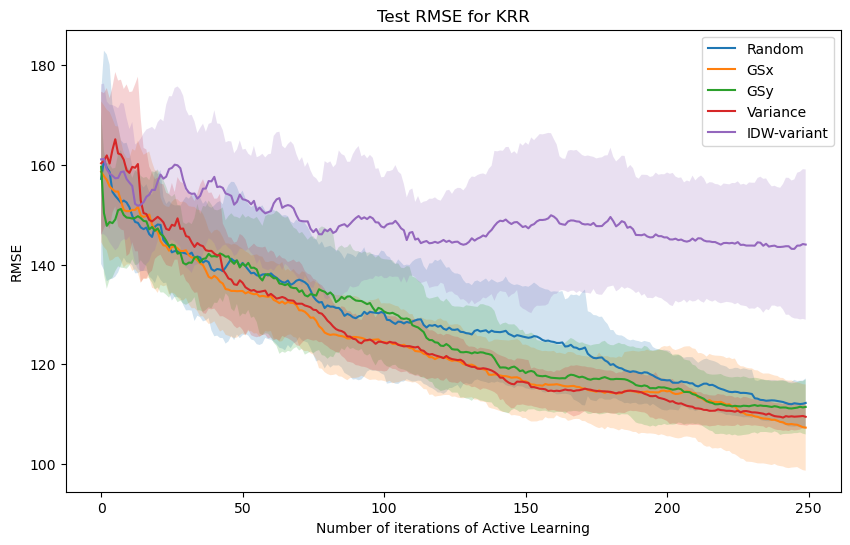

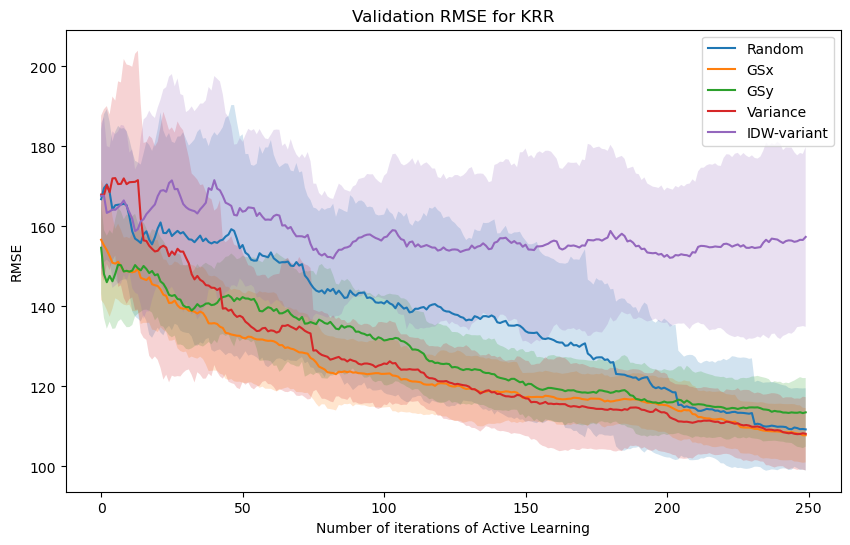

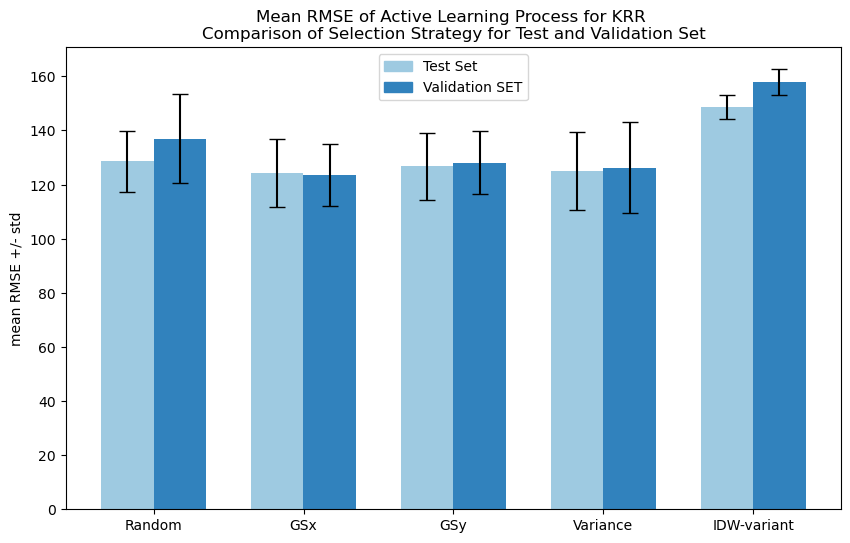

In [34]:
filepath = FIGURE_PATH
report_al_results(data_krr, "KRR", filepath, selection_criteria=selection_criteria)

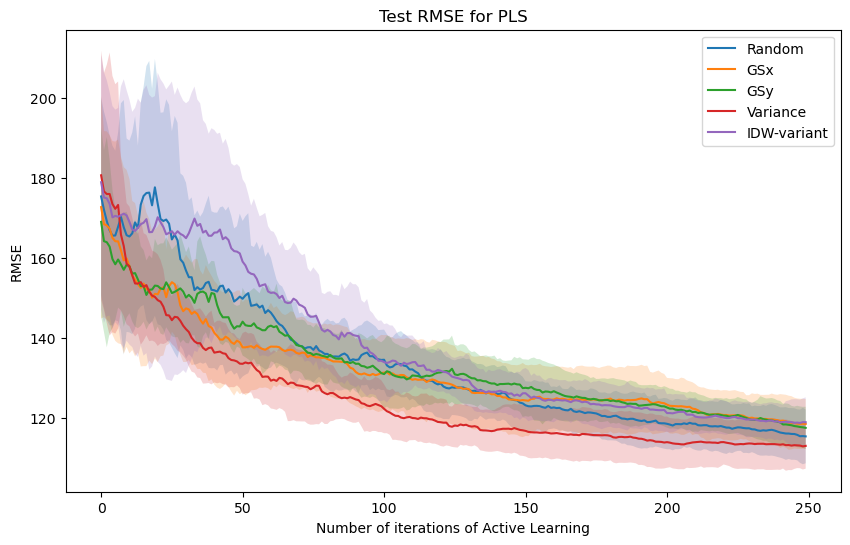

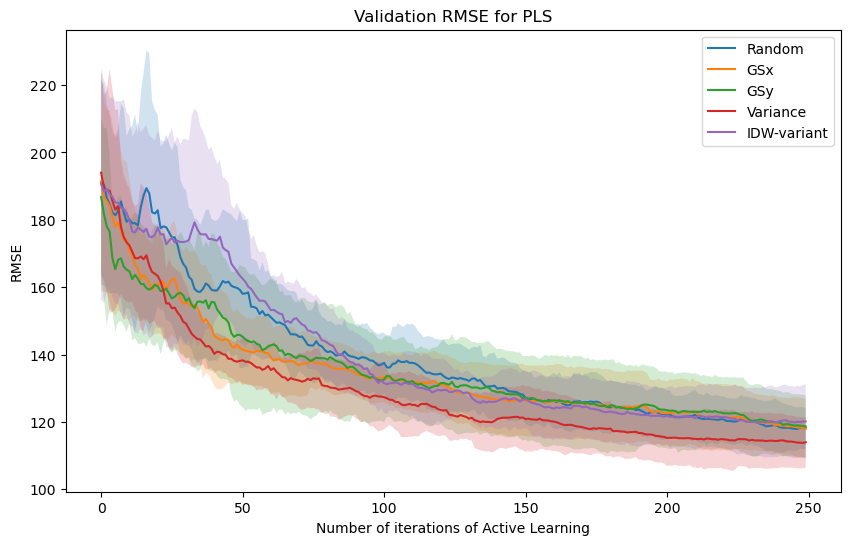

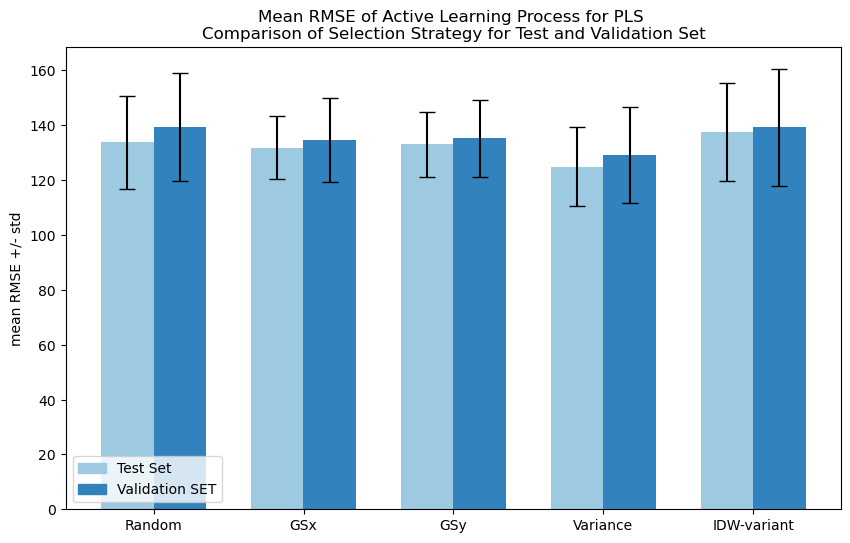

In [35]:
report_al_results(
    data_pls, model_name="PLS", filepath=filepath, selection_criteria=selection_criteria
)

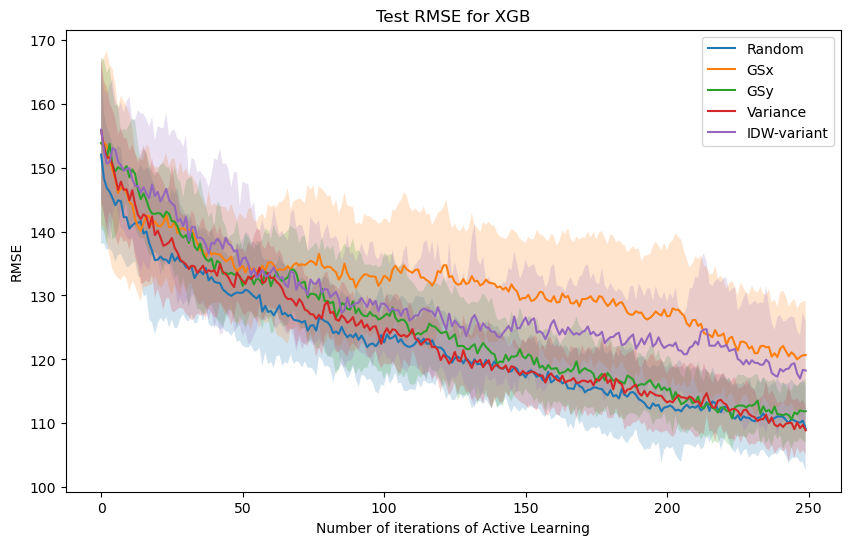

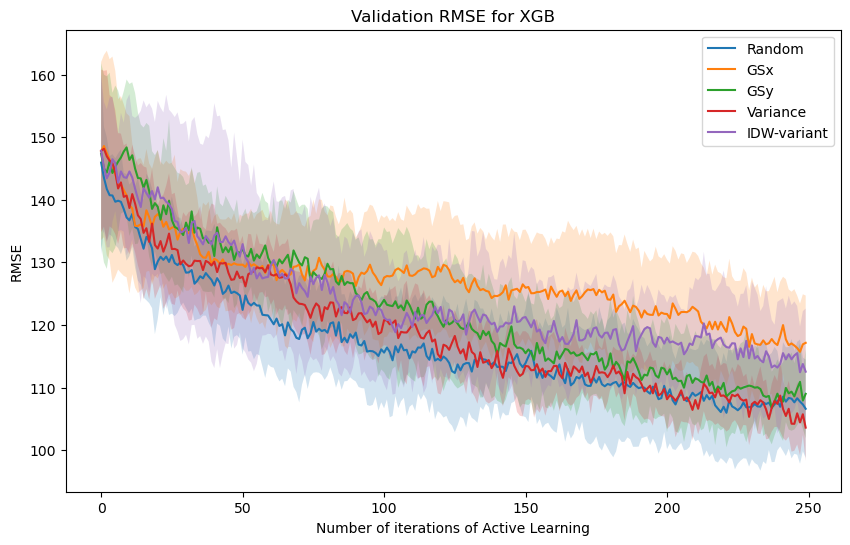

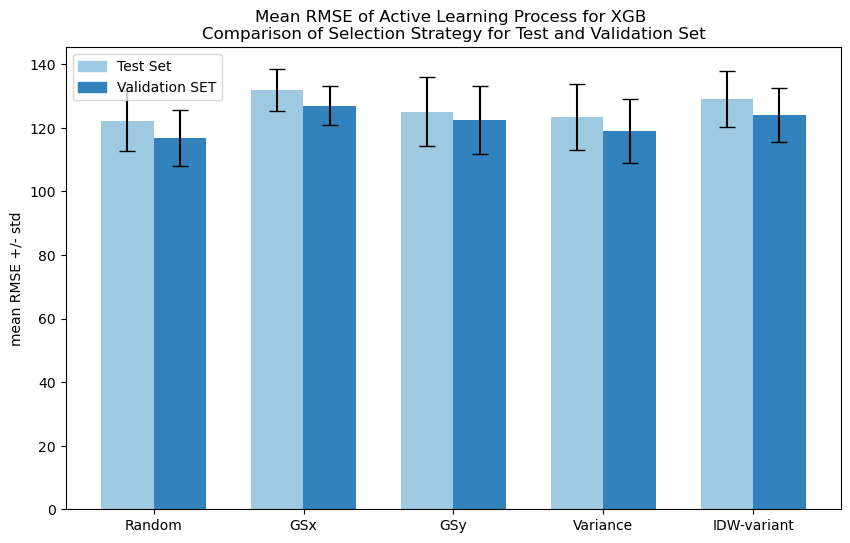

In [36]:
report_al_results(
    data_xgb, model_name="XGB", filepath=filepath, selection_criteria=selection_criteria
)

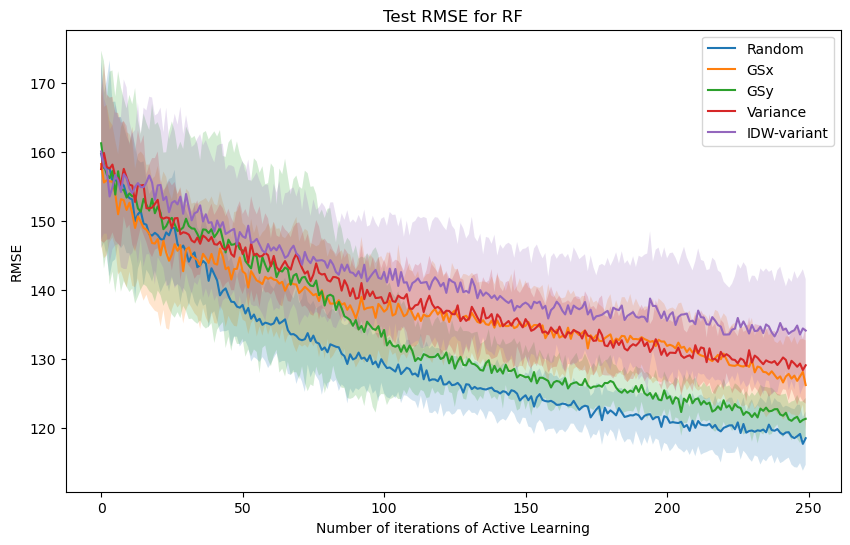

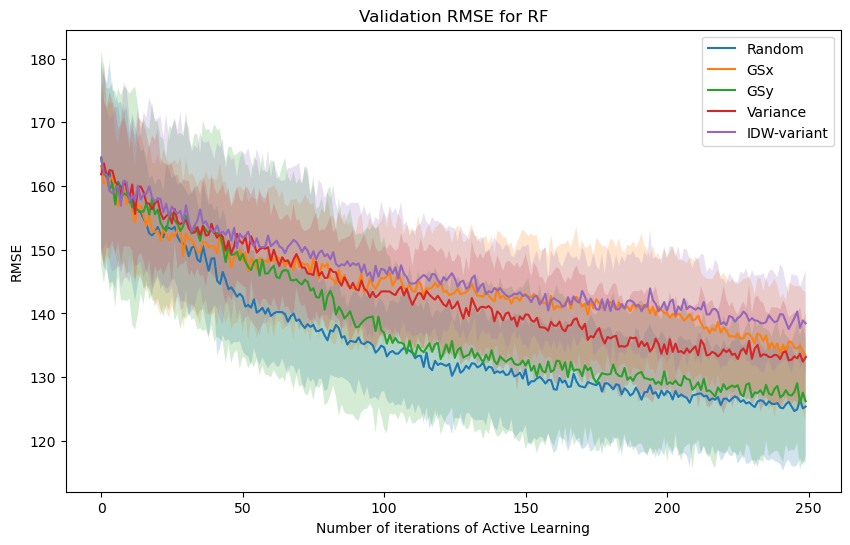

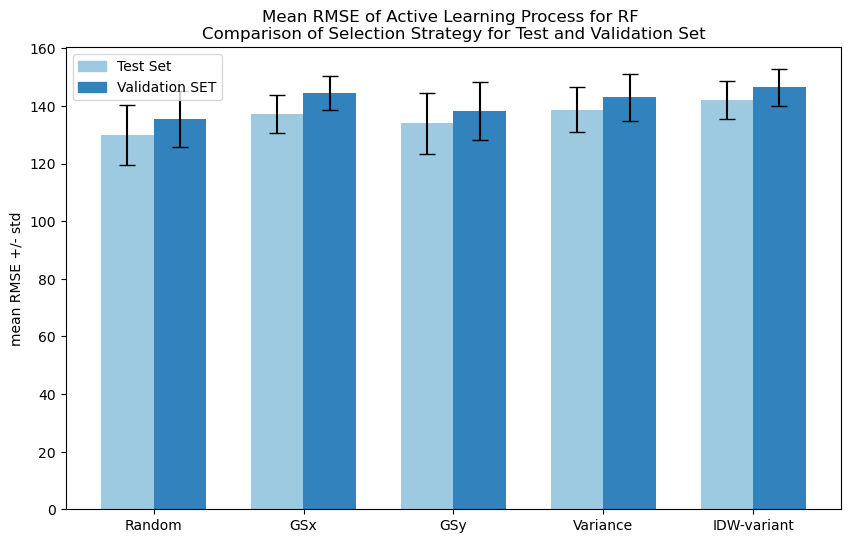

In [37]:
report_al_results(
    data_rf, model_name="RF", filepath=filepath, selection_criteria=selection_criteria
)

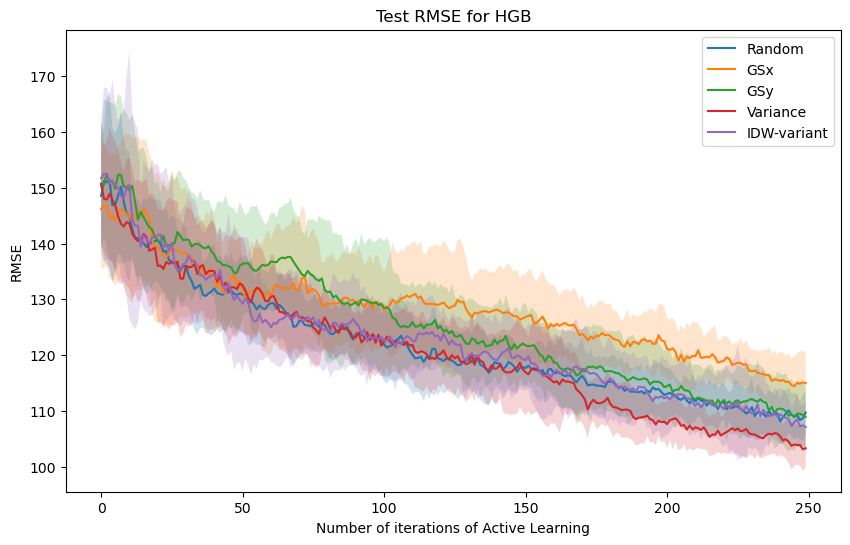

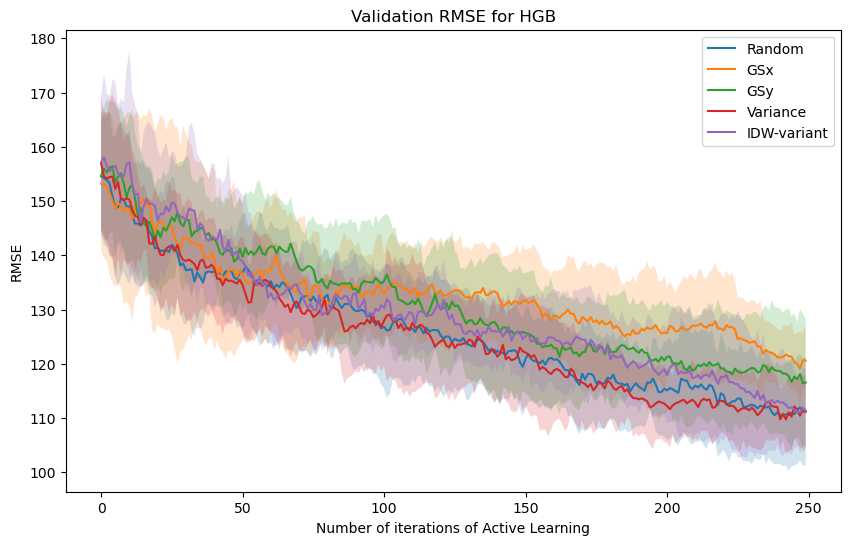

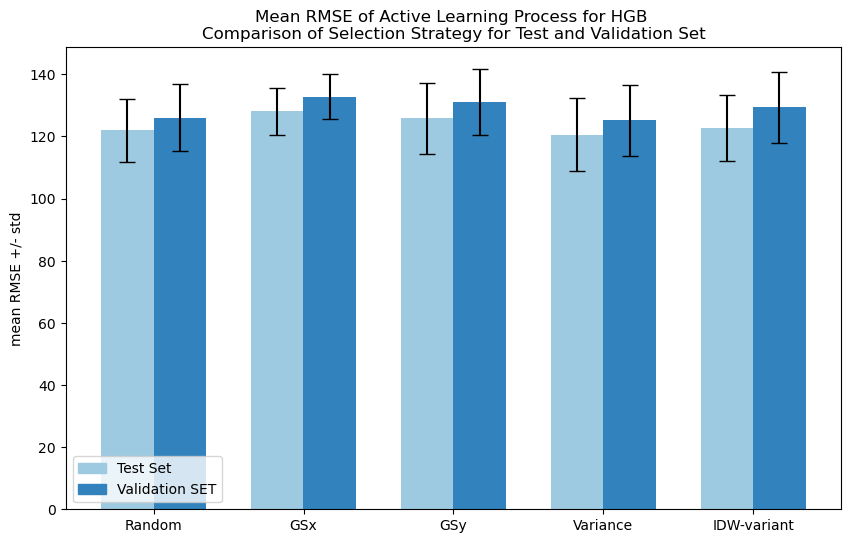

In [38]:
report_al_results(data_hgb, "HGB", filepath, selection_criteria=selection_criteria)